In [3]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import utils

In [4]:
qfs = pd.read_json("../data/output_data/qwen_fs.json")
qzs = pd.read_json("../data/output_data/qwen_zs.json")
mfs = pd.read_json("../data/output_data/mullama_fs.json")
mzs = pd.read_json("../data/output_data/mullama_zs.json")

qfs = utils.parse_df(qfs, experiment_name="qwen_fs")
qzs = utils.parse_df(qzs, experiment_name="qwen_zs")
mfs = utils.parse_df(mfs, experiment_name="mu_fs")
mzs = utils.parse_df(mzs, experiment_name="mu_zs")

print("qfs accuracy =", utils.accuracy(qfs))
print("qzs accuracy =", utils.accuracy(qzs))
print("mfs accuracy =", utils.accuracy(mfs))
print("mzs accuracy =", utils.accuracy(mzs))

/home/gigibs/Documents/research/2025_investigating_mmshap/src/experiments/mmshap.py:17: RuntimeWarning: invalid value encountered in scalar divide
  text_score = text_contrib / (text_contrib + audio_contrib)
/home/gigibs/Documents/research/2025_investigating_mmshap/src/experiments/mmshap.py:18: RuntimeWarning: invalid value encountered in scalar divide
  audio_score = audio_contrib / (text_contrib + audio_contrib)
/home/gigibs/Documents/research/2025_investigating_mmshap/src/experiments/mmshap.py:17: RuntimeWarning: invalid value encountered in scalar divide
  text_score = text_contrib / (text_contrib + audio_contrib)
/home/gigibs/Documents/research/2025_investigating_mmshap/src/experiments/mmshap.py:18: RuntimeWarning: invalid value encountered in scalar divide
  audio_score = audio_contrib / (text_contrib + audio_contrib)


qfs accuracy = 0.4426229508196721
qzs accuracy = 0.47218934911242605
mfs accuracy = 0.27014218009478674
mzs accuracy = 0.3277661795407098


In [5]:
len(qfs), len(qzs), len(mfs), len(mzs)

(488, 845, 844, 479)

In [6]:
qzs

,id,prompt,answers,answer_orders,dataset,genre,reasoning,knowledge,audio_path,model_output,...,final_answer,question,a_shap,t_shap,input_tokens,output_tokens,input_ids,experiment,len_output,n_output_tokens
question_id,,,,,,,,,,,,,,,,,,,,,
611,FENJIDecy5s,Question: What type of sound is used for the b...,"[Analog bass sound, The bassline repeats, Digi...","[1, 2, 0, 3]",musiccaps,Electronic,[],"[sound texture, instrumentation]",musiccaps/audio/FENJIDecy5s_80.wav,The type of sound used for the bassline in thi...,...,1,What type of sound is used for the bassline in...,0.175550,0.824450,"[\n, Question, :, What, type, of, sound, ...","[The, type, of, sound, used, for, the, ...","[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11,...",qwen_zs,75,17
996,DU5pD63Pv30,Question: What is the main characteristic of t...,"[The advertisement is a jingle, Goofy, Romanti...","[2, 0, 3, 1]",musiccaps,Electronic,[mood and expression],[],musiccaps/audio/DU5pD63Pv30_20.wav,The main characteristic of the accordion tune ...,...,0,What is the main characteristic of the accordi...,0.210308,0.789692,"[\n, Question, :, What, is, the, main, ch...","[The, main, characteristic, of, the, acco...","[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11,...",qwen_zs,58,10
672,W0aT3SdtnfY,Question: What vocal technique are the singers...,"[Using auto-tuning effects, The acoustic piano...","[3, 2, 0, 1]",musiccaps,Funk / Soul,[],[performance],musiccaps/audio/W0aT3SdtnfY_30.wav,The singers are primarily using the vocal tech...,...,1,What vocal technique are the singers primarily...,0.268294,0.731706,"[\n, Question, :, What, vocal, technique, ...","[The, singers, are, primarily, using, the...","[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11,...",qwen_zs,86,17
1165,rJZgUpzqAyY,"Question: Besides the drums, which instrument ...","[Male voices singing a simple melody, Electric...","[2, 0, 3, 1]",musiccaps,Rock,[],[instrumentation],musiccaps/audio/rJZgUpzqAyY_70.wav,Male voices singing a simple melody contribute...,...,0,"Besides the drums, which instrument contribute...",0.237347,0.762653,"[\n, Question, :, Besides, the, drums, ,, ...","[Male, voices, singing, a, simple, melody...","[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11,...",qwen_zs,83,17
854,xUVvBF9BWdg,Question: How does the backup singer participa...,"[Vocal harmony, Male lead singer, Saxophone so...","[0, 2, 1, 3]",musiccaps,Reggae,[mood and expression],[],musiccaps/audio/xUVvBF9BWdg_30.wav,The backup singer participates in this perform...,...,1,How does the backup singer participate in this...,0.216131,0.783869,"[\n, Question, :, How, does, the, backup, ...","[The, backup, singer, participates, in, t...","[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11,...",qwen_zs,76,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,6k4lcF9IGUk,"Question: Aside from the vocals and the piano,...","[Sung by the main vocalist, Banging sound and ...","[2, 0, 1, 3]",musiccaps,Electronic,[],"[sound texture, instrumentation]",musiccaps/audio/6k4lcF9IGUk_150.wav,"Aside from the vocals and the piano, the addit...",...,0,"Aside from the vocals and the piano, what addi...",0.205673,0.794327,"[\n, Question, :, Aside, from, the, vocals...","[Aside, from, the, vocals, and, the, pia...","[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11,...",qwen_zs,107,22
624,MvnC1TfNiPY,Question: What is the overall mood conveyed by...,"[The song is about love and relationships, Mel...","[3, 1, 2, 0]",musiccaps,Electronic,[mood and expression],[],musiccaps/audio/MvnC1TfNiPY_90.wav,The overall mood conveyed by this music piece ...,...,1,What is the overall mood conveyed by this musi...,0.211488,0.788512,"[\n, Question, :, What, is, the, overall, ...","[The, overall, mood, conveyed, by, this, ...","[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11,...",qwen_zs,70,13
1174,TPYNIc_M1ng,Question: What is the primary musical genre re...,"[Classical, Funk, Jazz, Bouncy and intricate]","[3, 0, 1, 2]",musiccaps,Electronic,[genre and style

In [7]:
qfs["a_shap"].mean(), qzs["a_shap"].mean(), mfs["a_shap"].mean(), mzs["a_shap"].mean()

(0.23237956445994998,
 0.2114338134338033,
 0.48406717642642827,
 0.47159925129579056)

In [18]:
agg_df = pd.concat([qzs, qfs, mfs, mzs])
agg_df.groupby(["experiment"]).agg({"a_shap": ["mean", "std", "max", "min"]})

a_shap                              
                mean       std       max       min
experiment                                        
mu_fs       0.484067  0.024049  0.550254  0.395354
mu_zs       0.471599  0.024990  0.568076  0.404678
qwen_fs     0.232380  0.026473  0.313072  0.118992
qwen_zs     0.211434  0.028897  0.336418  0.101766

In [8]:
qfs.isnull().values.any(), qzs.isnull().values.any(), mfs.isnull().values.any(),  mzs.isnull().values.any()

(False, False, True, True)

In [9]:
qfs[["a_shap"]].max(), qzs[["a_shap"]].max(), mfs[["a_shap"]].max(), mzs[["a_shap"]].max(), 

(a_shap    0.313072
 dtype: float64,
 a_shap    0.336418
 dtype: float64,
 a_shap    0.550254
 dtype: float64,
 a_shap    0.568076
 dtype: float64)

## Check average answer length for different experiments

In [10]:
agg_df = pd.concat([qzs, qfs, mfs, mzs])

In [11]:
len(agg_df["input_tokens"].iloc[0])

54

In [12]:
agg_df.groupby("experiment").agg({"len_output": "mean", "n_output_tokens": "mean", "a_shap": "mean"})

,len_output,n_output_tokens,a_shap
experiment,,,
mu_fs,52.117299,12.444313,0.484067
mu_zs,57.144050,13.586639,0.471599
qwen_fs,75.075820,15.989754,0.232380
qwen_zs,97.681657,20.347929,0.211434


In [52]:
tmp = agg_df.groupby(["experiment", "genre"]).agg({"len_output": "mean", "a_shap": "mean"})

In [53]:
# Assuming your DataFrame is named 'df'
tmp = tmp.reset_index()  

pivoted_df = tmp.set_index(['genre', 'experiment']).unstack(level='experiment')

# Optional: Reorder the multi-level columns if needed
pivoted_df = pivoted_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

pivoted_df

experiment                 mu_fs                mu_zs              qwen_fs  \
                          a_shap len_output    a_shap len_output    a_shap   
genre                                                                        
Blues                   0.486792  57.222222  0.467974  57.900000  0.232462   
Classical               0.484662  56.944444  0.469976  60.800000  0.222082   
Electronic              0.482255  59.039062  0.471199  56.295455  0.224219   
Folk, World, & Country  0.484319  52.059259  0.465902  58.802469  0.233777   
Funk / Soul             0.483687  44.403846  0.470937  55.763158  0.238799   
Hip Hop                 0.481228  50.781250  0.474122  51.900000  0.231748   
Jazz                    0.486319  51.900000  0.477584  53.058824  0.251755   
Latin                   0.486092  65.500000  0.479833  61.920000  0.235397   
Pop                     0.484552  45.170732  0.475903  58.348485  0.233233   
Reggae                  0.485323  45.977778  0.469339  49.380952  0.225460   
Rock                    0.484175  51.267516  0.471176  58.385542  0.235647   

experiment                          qwen_zs              
                       len_output    a_shap  len_output  
genre                                                    
Blues                   97.500000  0.232673   99.055556  
Classical               97.150000  0.209616  114.194444  
Electronic              74.844444  0.207039  113.078740  
Folk, World, & Country  73.988095  0.215474   95.087591  
Funk / Soul             82.578947  0.212324   96.692308  
Hip Hop                 65.800000  0.206631   88.078125  
Jazz                    79.470588  0.208766  119.100000  
Latin                   88.888889  0.219708  107.326087  
Pop                     63.343284  0.210394   79.569106  
Reggae                  61.523810  0.210760  100.222222  
Rock                    75.821429  0.210371   92.968153

# Is there a relationship between the type of question and the A-SHAP?

It is hard to tell only from the analysis below. I need a better way of aggregating the type of question. I don't like that it is a list.

In [57]:
agg_df["knowledge_as_tuple"] = agg_df["knowledge"].apply(tuple)

In [70]:
a = agg_df.groupby(["experiment", "knowledge_as_tuple"]).agg({"n_output_tokens": "mean", "a_shap": "mean", "prompt": "count"})

In [73]:
b = a.reset_index()
b.sort_values("a_shap", ascending=False)

,experiment,knowledge_as_tuple,n_output_tokens,a_shap,prompt
21,mu_fs,"(sound texture, dynamics and expression)",27.000000,0.522808,1
48,mu_zs,"(sound texture, metre and rhythm, instrumentat...",23.000000,0.518838,1
33,mu_zs,"(instrumentation, metre and rhythm)",31.000000,0.514654,1
4,mu_fs,"(harmony, melody, instrumentation, metre and r...",25.000000,0.501995,1
9,mu_fs,"(melody,)",13.153846,0.500362,13
...,...,...,...,...,...
66,qwen_fs,"(performance, dynamics and expression)",13.000000,0.201118,1
83,qwen_zs,"(instrumentation, performance)",12.000000,0.177291,1
91,qwen_zs,"(performance, dynamics and expression)",13.000000,0.174148,1
88,qwen_zs,"(metre and rhythm, dynamics and expression)",13.500000,0.169317,2


# Is there a relationship between number of output tokens and A-SHAP value?
From a first glimpse, It looked like yes. But after plotting the results below, I don't think that we have a relationship. I think that the stronger relationship might appear if we remove stopwords from the answer rather than just checking the lenght of the answer itself.

Also, by doing this analysis I found some outliers that I was not expecting. This could be biasing the average length of the output, so I changed it from mean to median. In here, I remove the outliers to maybe have a better interpretation of the plots. I left an outlier example by the end of this section.

Text(0.5, 0.98, 'Number of output tokens vs A-SHAP')

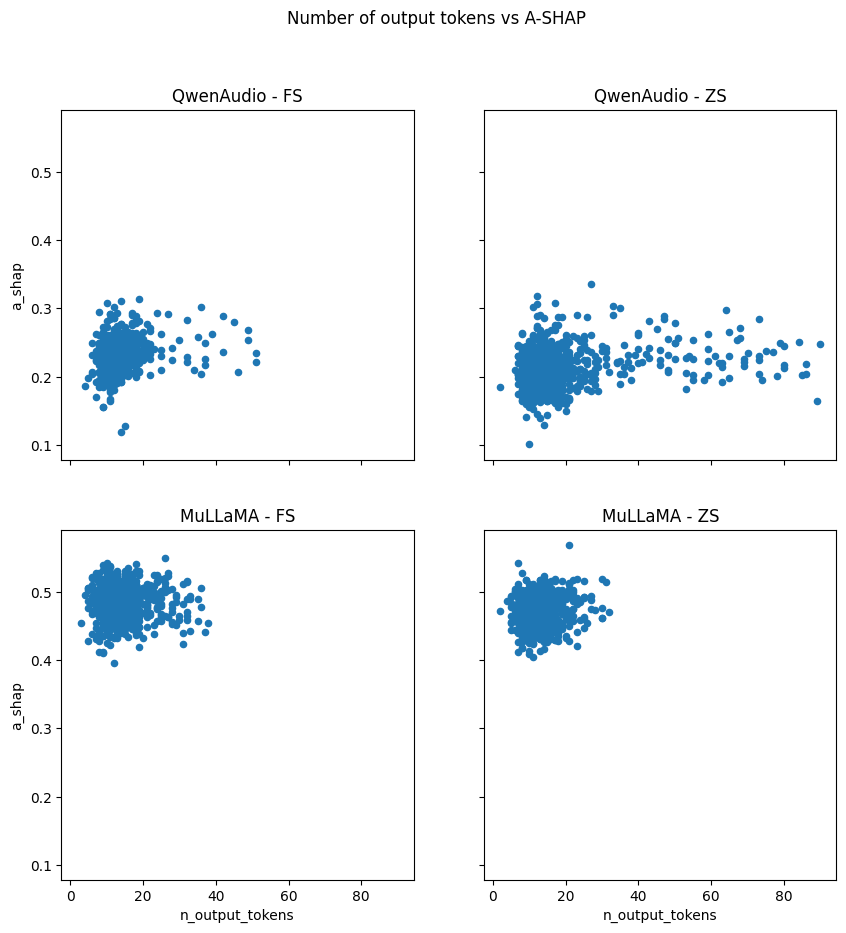

In [89]:
fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True, sharex=True)

# QwenAudio - few shot wo outliers
(
    qfs[np.abs(stats.zscore(qfs["n_output_tokens"])) < 3][["n_output_tokens", "a_shap"]]
        .sort_values(by="n_output_tokens")
        .plot.scatter(x="n_output_tokens", y="a_shap", ax=ax[0][0])
)
ax[0][0].set(title="QwenAudio - FS")

# QwenAudio - zero shot
(
    qzs[np.abs(stats.zscore(qzs["n_output_tokens"])) < 3]
        .sort_values(by="n_output_tokens").plot.scatter(x="n_output_tokens", y="a_shap", ax=ax[0][1])
)
ax[0][1].set(title="QwenAudio - ZS")

# MuLlaMA - few shot wo outliers
(
    mfs[np.abs(stats.zscore(mfs["n_output_tokens"])) < 3][["n_output_tokens", "a_shap"]]
        .sort_values(by="n_output_tokens")
        .plot.scatter(x="n_output_tokens", y="a_shap", ax=ax[1][0])
)
ax[1][0].set(title="MuLLaMA - FS")

# MuLLaMA - zero shot wo outliers
(
    mzs[np.abs(stats.zscore(mzs["n_output_tokens"])) < 3][["n_output_tokens", "a_shap"]]
        .sort_values(by="n_output_tokens")
        .plot.scatter(x="n_output_tokens", y="a_shap", ax=ax[1][1])
)
ax[1][1].set(title="MuLLaMA - ZS")

fig.suptitle("Number of output tokens vs A-SHAP")

### Example of the answer with the maximum number of tokens of each experiment

In [90]:
# qwen - few shot
qfs.loc[qfs[["n_output_tokens"]].idxmax()]["model_output"].values

array(['The most suitable use for this piece of music would be as a soundtrack for a movie or video game, as it has a dramatic and suspenseful tone that would fit well with scenes of action or tension. The shout-like vocal style and brass instruments could add to the intensity of the music and create a sense of urgency or danger. It may also be suitable for use in a folk dance, as the music has a traditional or ethnic feel. However, the use of digital drums in the rhythm pattern may not be entirely authentic to a particular folk dance.'],
      dtype=object)

In [91]:
# qwen - zero shot
qzs.loc[qzs[["n_output_tokens"]].idxmax()]["model_output"].values

array(['Based on the voice, it sounds like the vocals are in a French accent, saying, "J\'ai toujours été heureux, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, toujours aimé, 

In [92]:
# mu - few shot
mfs.loc[mfs[["n_output_tokens"]].idxmax()]["model_output"].values

array(['(A) Flat female vocal, wide background harmonizing vocals (B) Saxophone solo (C) Uptempo and energetic overall feel (D) Acoustic rhythm guitar, offbeat shimmering open hats, claps, offbeat synth keys chords, groovy bass'],
      dtype=object)

In [93]:
# mu - zero shot
mzs.loc[mzs[["n_output_tokens"]].idxmax()]["model_output"].values

array(["The vocalist's accentuated delivery is reminiscent of Michael Jackson's style, while the use of synthesizers and electronic drums is influenced by Kendrick Lamar's music."],
      dtype=object)

# Is there a relationship between the audio usage and getting the correct answer?

In [12]:
agg_df = pd.concat([qzs, qfs, mfs, mzs])

In [14]:
agg_df.groupby(["experiment", "final_answer"]).agg({"a_shap": "median"})

a_shap
experiment final_answer          
mu_fs      -1            0.482874
            0            0.483581
            1            0.484356
mu_zs      -1            0.482489
            0            0.472554
            1            0.467752
qwen_fs    -1            0.231890
            0            0.232204
            1            0.230250
qwen_zs    -1            0.213981
            0            0.210392
            1            0.208273